# Examine changes in viable habitat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from itertools import product
import json
import yaml
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import funnel
import data_collections as dc
import operators as ops
import util

import metabolic as mi

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
curator = util.curator_local_assets()
cat = curator.open_catalog()  
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_wgt

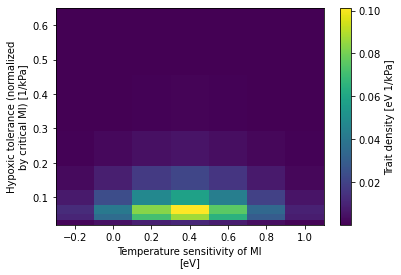

In [4]:
trait_spc_wgt.plot();

In [5]:
dEodT_bar = mi.dEodT_bar
dEodT_bar

0.022

In [6]:
    catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[1:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,31
variable,8
name,1
path,393


In [7]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [8]:
cache_dir = '/glade/scratch/mclong/ocean-metabolism/funnel-cache'

def _gen_cache_file_name(experiment, component, stream, member_id, variable):
    return f'{cache_dir}/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.zarr'


def _make_cache(experiment, component, stream, member_id, variable):
    """
    Manually generate funnel catalog entry
    
    I.e.:
    asset: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.zarr
    esm_collection: data/catalogs/glade-cesm1-le.json
    key: 20C.ocn.pop.h.101
    name: drift-corrected
    operator_kwargs:
    - {}
    - {}
    - {}
    operators:
    - compute_time
    - sel_time_slice
    - compute_drift_correction
    preprocess: _preprocess_pop_h_upper_1km
    variable: TEMP
    """
    
    cache_id_dict = dict(
        asset=_gen_cache_file_name(experiment, component, stream, member_id, variable),
        esm_collection='data/catalogs/glade-cesm1-le.json',        
        key=f'{experiment}.{component}.{stream}.{member_id}',
        name='drift-corrected',
        operator_kwargs=[{}, {}, {}],
        operators=['compute_time', 'sel_time_slice', 'compute_drift_correction'],
        preprocess='_preprocess_pop_h_upper_1km',
        variable=variable,
    )
    cache_id_file = f'data/funnel-catalog/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.yml'
    with open(cache_id_file, 'w') as fid:
        yaml.dump(cache_id_dict, fid)    
        

In [9]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='6GB')
    cluster.scale(200)
client    

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45093 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/45093/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/45093/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.22:37658,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/45093/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [13]:
clobber = False

do_apply_ufunc = False

stream = 'pop.h'
component = 'ocn'
    
variable = 'vol_habitat_trait_spc'

# compute Phi over trait space
for experiment, member_id in product(experiment_list, member_id_list):
    # check for existing cache file        

    asset = _gen_cache_file_name(experiment, component, stream, member_id, variable)

    if clobber and os.path.exists(asset):
        print(f'removing: {asset}')
        shutil.rmtree(asset)

    if os.path.exists(asset):
        print(f'exists: {asset}')
        continue    

        
    with util.timer(f'{experiment}.{member_id}'):    
        
        cat = catalog.search(
            experiment=experiment, 
            member_id=member_id,         
            stream=stream, 
            component=component,
            variable=['TEMP', 'pO2'],
        )

        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1    
        _, ds = dset.popitem()

        dso = xr.Dataset()
        dso['Eo'] = trait_spc_wgt.Eo
        dso['Ac'] = trait_spc_wgt.Ac

        vol = ds.dz * ds.TAREA

        print(f'computing: {asset}')
        da_list_outer = []
        for i, Ac in enumerate(trait_spc_wgt.Ac.values):

            da_list_inner = []        
            for j, Eo in enumerate(trait_spc_wgt.Eo.values):

                if do_apply_ufunc:
                    Phi = xr.apply_ufunc(
                        mi.Phi, 
                        ds.pO2, ds.TEMP, 
                        kwargs=dict(Ac=Ac, Eo=Eo, dEodT=dEodT_bar),
                        dask='parallelized',
                    )
                else:            
                    Phi = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)

                viability_mask = xr.where(Phi > 1, 1.0, 0.0) 

                da_list_inner.append(
                    (vol * viability_mask).sum(['z_t', 'nlat', 'nlon']).compute()
                )

            da_list_outer.append(xr.concat(da_list_inner, dim=trait_spc_wgt.Eo))

        print(f'writing: {asset}')    
        dso[variable] = xr.concat(da_list_outer, dim=trait_spc_wgt.Ac)

        dso.to_zarr(asset, mode='w', consolidated=True)    
        _make_cache(experiment, component, stream, member_id, variable)


exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.vol_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/f

In [ ]:
del client
del cluster